# ISPR Home Work 3

### Student: Moroni Luca
### Mat: 635966

## Assignment: 1

## Importing used libraries

In [259]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from torch.nn import functional as F
from sklearn.utils import gen_batches
from torchviz import make_dot, make_dot_from_trace

from torch import nn
from torch import optim

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-q2az7277
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-q2az7277


In [260]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset from sklearn

This method permit to don't upload the files each time
I choose to use directly the tensors of pytorch without using the dataloader build-in because the dataset of MNIST is not such huge, and because is needed to modify the dataset on the fly to implement the layerwise pretraining of the deep autoencoder.

In [261]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

MNIST_train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

X_train = MNIST_train_dataset.data.float()
y_train = MNIST_train_dataset.targets

# rescale in [0, 1]
X_train -= torch.min(X_train)
X_train /= torch.max(X_train)

# resize the dataset
X_train = X_train.view(-1, 784)

MNIST_test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

X_test = MNIST_test_dataset.data.float()
y_test = MNIST_test_dataset.targets

# rescale in [0, 1]
X_test -= torch.min(X_test)
X_test /= torch.max(X_test)

# resize the dataset
X_test = X_test.view(-1, 784)

### Show some images

In [262]:
def show_table_images(data, text, dim = 10):
  plt.figure(figsize=(dim*2, dim*2))
  for i, comp in enumerate(data):
      plt.subplot(dim, dim, i + 1)
      plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
  plt.suptitle(text, fontsize=16)
  plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

  plt.show()

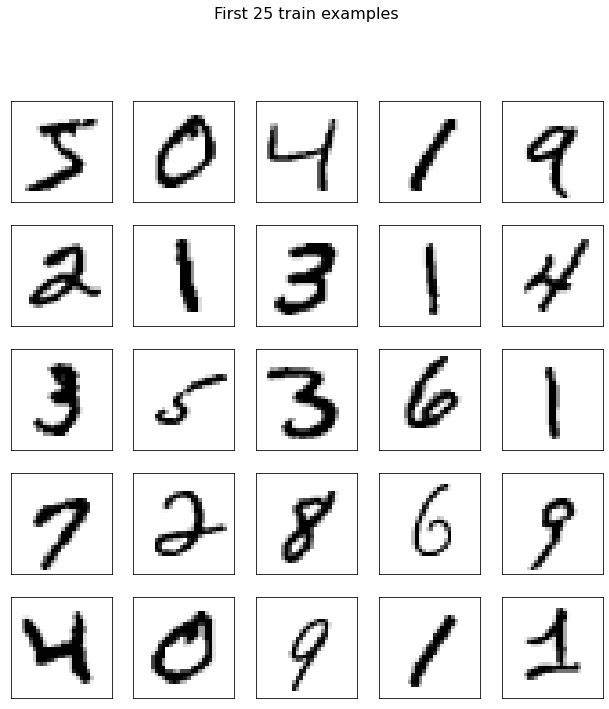

In [263]:
show_table_images(X_train.numpy()[:25], "First 25 train examples", 5)

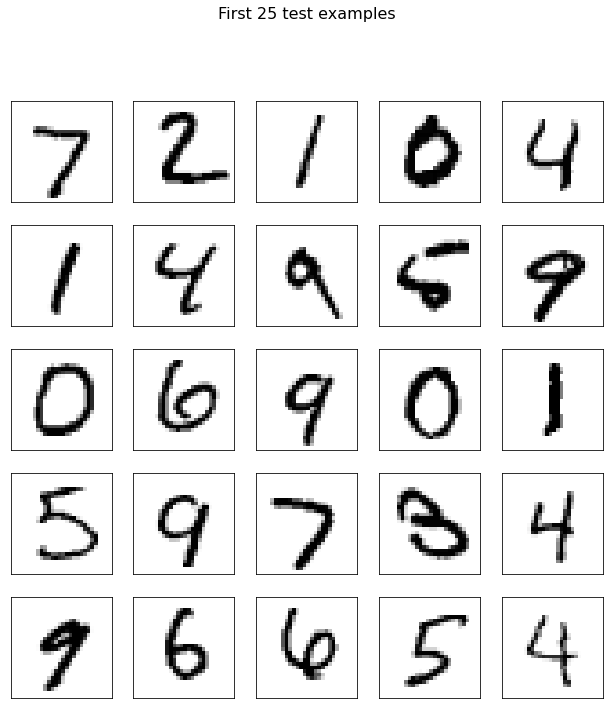

In [264]:
show_table_images(X_test.numpy()[:25], "First 25 test examples", 5)

## Autoencoders

I choose to implement the denoising autoencoder.

In [265]:
def noise_dataset(X, mean = 0, std = 0.1):
  # add gaussian noise
  X += torch.randn(X.shape).to(device)*std + mean
  # rescale in [0, 1]
  X -= torch.min(X)
  X /= torch.max(X)

  return X

In [266]:
def evaluate_MSE(model, eval_dataset):
  with torch.no_grad():
    eval_output = model(eval_dataset.to(device))

    loss = F.mse_loss(eval_output, eval_dataset.to(device))
  
  return loss.item()

In [267]:
def denoising_autoencoder_training(epochs, batch_size, X_train, model, lr, first_layer = True, X_test=None):
  # create an optimizer object
  # Adam optimizer
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # mean-squared error loss
  criterion = nn.MSELoss()

  history = {"train_errors": [], "test_errors" : []}

  for epoch in range(epochs):
      for batch in gen_batches(len(X_train), batch_size):
        batch_start = batch.start
        batch_stop = batch.stop
        X_batch = X_train[batch_start:batch_stop].to(device)
        
        # add noise only if the autoencoder is the first in a stack
        if first_layer:
          batch_features_in = noise_dataset(X_batch)
        else:
          batch_features_in = X_batch

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features_in)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, X_batch)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
                      
      # display the epoch training loss
      epoch_train_error = evaluate_MSE(model, X_train)

      history["train_errors"].append(epoch_train_error)

      if not X_test is None:
        epoch_test_error = evaluate_MSE(model, X_test)
        history["test_errors"].append(epoch_test_error)
        print(f"epoch : {epoch + 1}/{epochs}, train loss = {epoch_train_error:.6f}, test loss = {epoch_test_error:.6f}")
      else:
        print(f"epoch : {epoch + 1}/{epochs}, train loss = {epoch_train_error:.6f}")

  return history

### Single layer AutoEncoder

In [268]:
class AE(nn.Module):
    def __init__(self, input_shape=784, hidden_dimension=128, last=True):
        super().__init__()

        self.last = last

        self.encoder_layer = nn.Linear(
            in_features=input_shape, out_features=hidden_dimension
        )
        self.decoder_layer = nn.Linear(
            in_features=hidden_dimension, out_features=input_shape
        )

    def encode(self, X):
      encoded = self.encoder_layer(X)
      encoded = torch.relu(encoded)
      return encoded

    def decode(self, X):
      decoded = self.decoder_layer(X)
      if self.last:
        decoded = torch.sigmoid(decoded)
      else:
        decoded = torch.relu(decoded)
      return decoded

    def forward(self, features):
      encoded = self.encoder_layer(features)
      decoded = self.decoder_layer(encoded)
      return decoded

In [269]:
ae = AE(input_shape=784, hidden_dimension=128).to(device)

Showing the computational graph of the forward phase of an autoencoder

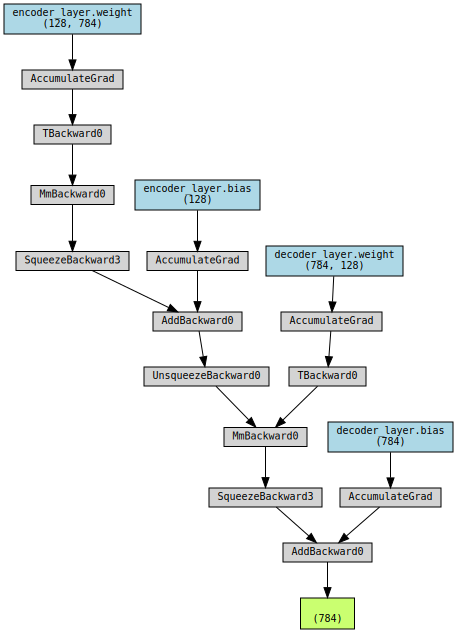

In [270]:
make_dot(ae(X_train[0].to(device)), params=dict(ae.named_parameters()))

In [271]:
history_ae = denoising_autoencoder_training(20, 128, X_train, ae, 1e-3, X_test=X_test)

epoch : 1/20, train loss = 0.019270, test loss = 0.018927
epoch : 2/20, train loss = 0.011966, test loss = 0.011726
epoch : 3/20, train loss = 0.009297, test loss = 0.009110
epoch : 4/20, train loss = 0.008302, test loss = 0.008146
epoch : 5/20, train loss = 0.007299, test loss = 0.007165
epoch : 6/20, train loss = 0.006936, test loss = 0.006831
epoch : 7/20, train loss = 0.006361, test loss = 0.006255
epoch : 8/20, train loss = 0.006262, test loss = 0.006177
epoch : 9/20, train loss = 0.005658, test loss = 0.005569
epoch : 10/20, train loss = 0.005583, test loss = 0.005498
epoch : 11/20, train loss = 0.005461, test loss = 0.005381
epoch : 12/20, train loss = 0.005733, test loss = 0.005660
epoch : 13/20, train loss = 0.005299, test loss = 0.005223
epoch : 14/20, train loss = 0.005098, test loss = 0.005023
epoch : 15/20, train loss = 0.005093, test loss = 0.005023
epoch : 16/20, train loss = 0.005133, test loss = 0.005067
epoch : 17/20, train loss = 0.005154, test loss = 0.005087
epoch 

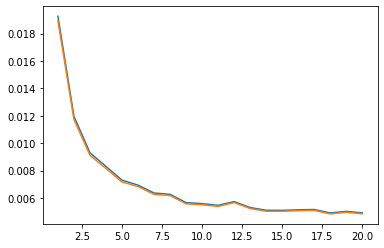

In [272]:
plt.plot(np.arange(20)+1, history_ae["train_errors"], label='train_errors')
plt.plot(np.arange(20)+1, history_ae["test_errors"], label="test_errors")
plt.show()

In [273]:
print(f"Shallow Train MSE: {evaluate_MSE(ae, X_train)}")
print(f"Shallow Test MSE: {evaluate_MSE(ae, X_test)}")

Shallow Train MSE: 0.004905726760625839
Shallow Test MSE: 0.004840334877371788


### Deep AutoEncoder

In [274]:
class DAE(nn.Module):
    def __init__(self, input_shape, hidden_layers=[128, 128]):
      super().__init__()

      if len(hidden_layers) < 2:
        raise Exception("Deep Autoencoders has to have at least 2 hidden layers")

      self.in_dimensions = [input_shape] + hidden_layers[:-1]

      self.autoencoders = [AE(input_shape, hidden_layers[0]).to(device)]
      
      for dim_in, dim_out in zip(hidden_layers[:-2], hidden_layers[1:-1]):
        self.autoencoders.append(AE(dim_in, dim_out, last=False).to(device))
      self.autoencoders.append(AE(hidden_layers[-2], hidden_layers[-1], last=False).to(device))

      self.autoencoders = nn.ModuleList(self.autoencoders)

    def encode(self, X):
      encoded = X
      for autoencoder in self.autoencoders:
        encoded = autoencoder.encode(encoded)
      return encoded

    def decode(self, X):
      decoded = X
      for autoencoder in self.autoencoders[::-1]:
        decoded = autoencoder.decode(decoded)
      return decoded

    def forward(self, X):
      encoded = self.encode(X)
      decoded = self.decode(encoded)
      return decoded

In [275]:
def denoising_autoencoder_pretraining(model, epochs, batch_size, X_train, lr):

  first_layer = True
  
  for in_dimension, autoencoder in zip(model.in_dimensions, model.autoencoders):
    denoising_autoencoder_training(epochs, batch_size, X_train, autoencoder, lr, first_layer = first_layer)
    
    with torch.no_grad():
      X_train = autoencoder.encode(X_train.to(device)).cpu()

    first_layer = False

### Denoising AutoEncoder with only pretraining

In [276]:
dae1 = DAE(784, [512, 256]).to(device)

Showing the computational graph of the forward phase of a deep autoencoder


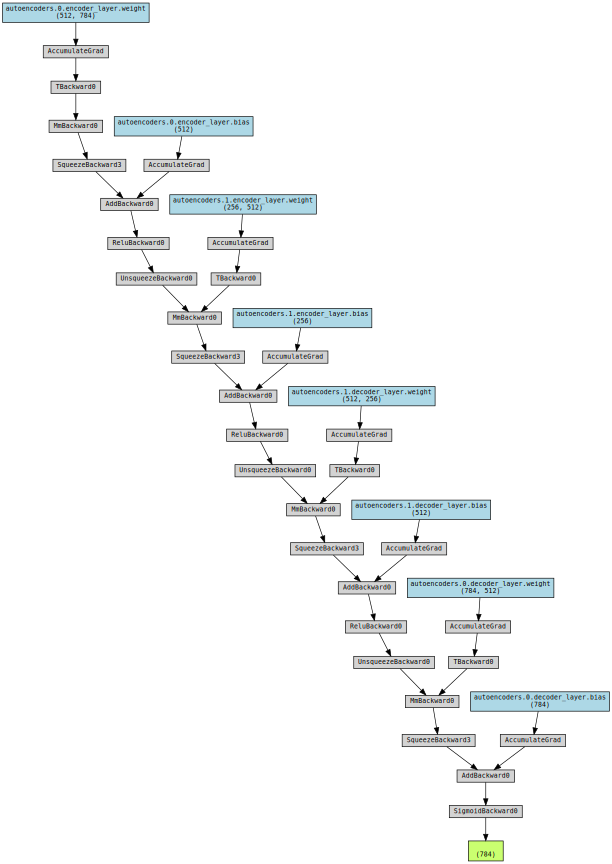

In [277]:
make_dot(dae1(X_train[0].to(device)), params=dict(dae1.named_parameters()))

In [278]:
denoising_autoencoder_pretraining(dae1, 50, 128, X_train, 1e-3)

epoch : 1/50, train loss = 0.007491
epoch : 2/50, train loss = 0.003846
epoch : 3/50, train loss = 0.002617
epoch : 4/50, train loss = 0.001913
epoch : 5/50, train loss = 0.001548
epoch : 6/50, train loss = 0.001322
epoch : 7/50, train loss = 0.001352
epoch : 8/50, train loss = 0.001004
epoch : 9/50, train loss = 0.001224
epoch : 10/50, train loss = 0.001603
epoch : 11/50, train loss = 0.001022
epoch : 12/50, train loss = 0.003466
epoch : 13/50, train loss = 0.001811
epoch : 14/50, train loss = 0.001347
epoch : 15/50, train loss = 0.000976
epoch : 16/50, train loss = 0.000728
epoch : 17/50, train loss = 0.000667
epoch : 18/50, train loss = 0.000540
epoch : 19/50, train loss = 0.000519
epoch : 20/50, train loss = 0.000472
epoch : 21/50, train loss = 0.000416
epoch : 22/50, train loss = 0.000385
epoch : 23/50, train loss = 0.000466
epoch : 24/50, train loss = 0.000512
epoch : 25/50, train loss = 0.000473
epoch : 26/50, train loss = 0.000549
epoch : 27/50, train loss = 0.000568
epoch : 28

In [279]:
print(f"Only pretraining Train MSE: {evaluate_MSE(dae1, X_train)}")
print(f"Only pretraining Test MSE: {evaluate_MSE(dae1, X_test)}")

Only pretraining Train MSE: 0.23787426948547363
Only pretraining Test MSE: 0.23776404559612274


### Denoising AutoEncoder with only fine tuning

In [280]:
dae2 = DAE(784, [512, 256]).to(device)

In [281]:
history_dae2 = denoising_autoencoder_training(50, 128, X_train, dae2, 1e-3, X_test=X_test)

epoch : 1/50, train loss = 0.114274, test loss = 0.113386
epoch : 2/50, train loss = 0.092829, test loss = 0.091751
epoch : 3/50, train loss = 0.096225, test loss = 0.095079
epoch : 4/50, train loss = 0.083347, test loss = 0.082205
epoch : 5/50, train loss = 0.075887, test loss = 0.074847
epoch : 6/50, train loss = 0.077267, test loss = 0.076408
epoch : 7/50, train loss = 0.070443, test loss = 0.069547
epoch : 8/50, train loss = 0.064198, test loss = 0.063403
epoch : 9/50, train loss = 0.067732, test loss = 0.067149
epoch : 10/50, train loss = 0.067858, test loss = 0.067002
epoch : 11/50, train loss = 0.064132, test loss = 0.063529
epoch : 12/50, train loss = 0.063829, test loss = 0.063191
epoch : 13/50, train loss = 0.059291, test loss = 0.058713
epoch : 14/50, train loss = 0.059580, test loss = 0.059104
epoch : 15/50, train loss = 0.056410, test loss = 0.055908
epoch : 16/50, train loss = 0.053008, test loss = 0.052540
epoch : 17/50, train loss = 0.053782, test loss = 0.053437
epoch 

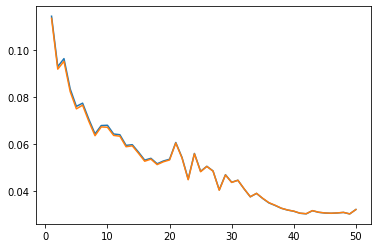

In [282]:
plt.plot(np.arange(50)+1, history_dae2["train_errors"], label='train_errors')
plt.plot(np.arange(50)+1, history_dae2["test_errors"], label="test_errors")
plt.show()

In [283]:
print(f"Pretraining and fine tuning Train MSE: {evaluate_MSE(dae2, X_train)}")
print(f"Pretraining and fine tuning Test MSE: {evaluate_MSE(dae2, X_test)}")

Pretraining and fine tuning Train MSE: 0.03199096769094467
Pretraining and fine tuning Test MSE: 0.03197223320603371


### Denoising AutoEncoder with pretraining and fine tuining

In [284]:
dae3 = DAE(784, [512, 256]).to(device)

In [285]:
denoising_autoencoder_pretraining(dae3, 50, 128, X_train, 1e-3)

epoch : 1/50, train loss = 0.007631
epoch : 2/50, train loss = 0.004011
epoch : 3/50, train loss = 0.002635
epoch : 4/50, train loss = 0.001883
epoch : 5/50, train loss = 0.001560
epoch : 6/50, train loss = 0.001294
epoch : 7/50, train loss = 0.001219
epoch : 8/50, train loss = 0.000975
epoch : 9/50, train loss = 0.000978
epoch : 10/50, train loss = 0.001219
epoch : 11/50, train loss = 0.000885
epoch : 12/50, train loss = 0.098988
epoch : 13/50, train loss = 0.001431
epoch : 14/50, train loss = 0.001132
epoch : 15/50, train loss = 0.001007
epoch : 16/50, train loss = 0.000812
epoch : 17/50, train loss = 0.000578
epoch : 18/50, train loss = 0.000774
epoch : 19/50, train loss = 0.000873
epoch : 20/50, train loss = 0.000768
epoch : 21/50, train loss = 0.000863
epoch : 22/50, train loss = 0.000534
epoch : 23/50, train loss = 0.000747
epoch : 24/50, train loss = 0.000622
epoch : 25/50, train loss = 0.000811
epoch : 26/50, train loss = 0.000696
epoch : 27/50, train loss = 0.001479
epoch : 28

In [286]:
history_dae3 = denoising_autoencoder_training(50, 128, X_train, dae3, 1e-3, X_test=X_test)

epoch : 1/50, train loss = 0.095124, test loss = 0.094164
epoch : 2/50, train loss = 0.077614, test loss = 0.076849
epoch : 3/50, train loss = 0.086195, test loss = 0.085530
epoch : 4/50, train loss = 0.074961, test loss = 0.074416
epoch : 5/50, train loss = 0.075629, test loss = 0.075186
epoch : 6/50, train loss = 0.070609, test loss = 0.070138
epoch : 7/50, train loss = 0.064438, test loss = 0.063903
epoch : 8/50, train loss = 0.064725, test loss = 0.064220
epoch : 9/50, train loss = 0.063468, test loss = 0.063187
epoch : 10/50, train loss = 0.056242, test loss = 0.055841
epoch : 11/50, train loss = 0.053034, test loss = 0.052758
epoch : 12/50, train loss = 0.060371, test loss = 0.060075
epoch : 13/50, train loss = 0.055269, test loss = 0.055056
epoch : 14/50, train loss = 0.050323, test loss = 0.050086
epoch : 15/50, train loss = 0.049954, test loss = 0.049686
epoch : 16/50, train loss = 0.050113, test loss = 0.049883
epoch : 17/50, train loss = 0.048449, test loss = 0.048270
epoch 

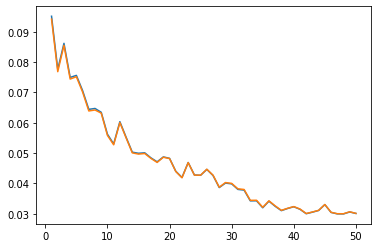

In [287]:
plt.plot(np.arange(50)+1, history_dae3["train_errors"], label='train_errors')
plt.plot(np.arange(50)+1, history_dae3["test_errors"], label="test_errors")
plt.show()

In [288]:
print(f"Pretraining and fine tuning Train MSE: {evaluate_MSE(dae3, X_train)}")
print(f"Pretraining and fine tuning Test MSE: {evaluate_MSE(dae3, X_test)}")

Pretraining and fine tuning Train MSE: 0.030118528753519058
Pretraining and fine tuning Test MSE: 0.03014586679637432


In [289]:
model = dae3.cpu()

## Latent space interpolation

In [290]:
# get three images, two from the same class and the third of another class

zero_class = y_test == 0
one_class = y_test == 1

z1 = X_test[zero_class][0]
z2 = X_test[zero_class][1]
z3 = X_test[one_class][0]

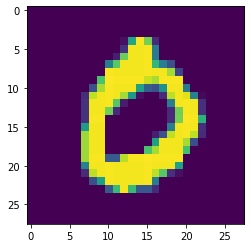

In [291]:
plt.imshow(z1.view((28,28)))
plt.show()

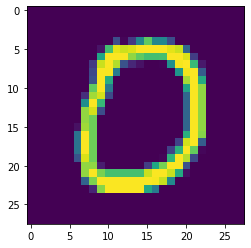

In [292]:
plt.imshow(z2.view((28,28)))
plt.show()

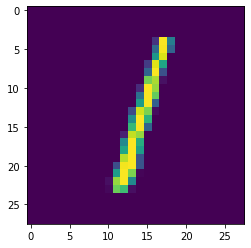

In [293]:
plt.imshow(z3.view((28,28)))
plt.show()

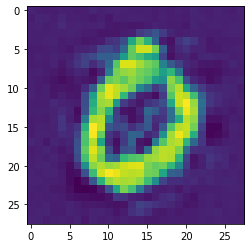

In [294]:
plt.imshow(model(z1).detach().reshape((28,28)))
plt.show()

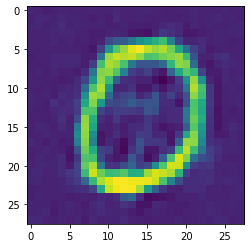

In [295]:
plt.imshow(model(z2).detach().reshape((28,28)))
plt.show()

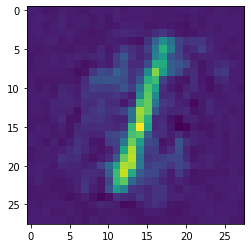

In [296]:
plt.imshow(model(z3).detach().reshape((28,28)))
plt.show()

In [297]:
def latent_space_interpolation(model, latent1, latent2):
  with torch.no_grad():
    enc1 = model.encode(latent1)
    enc2 = model.encode(latent2)

    progression_imgaes = [model.decode(enc2)]

    for i in range(1,10):

      alpha = i/10

      enc = alpha*enc1 + (1-alpha)*enc2

      dec = model.decode(enc)

      progression_imgaes.append(dec)

    progression_imgaes.append(model.decode(enc1))


    plt.figure(figsize=(11*2, 11*2))
    for i, comp in enumerate(progression_imgaes):
        plt.subplot(11, 11, (i + 1))
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest", )
        plt.title(f"alpha = {i/10}")
        plt.xticks(())
        plt.yticks(())
    plt.suptitle("Progression of the decoder fitted with convex comb. of two encoded images", fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

    plt.show()

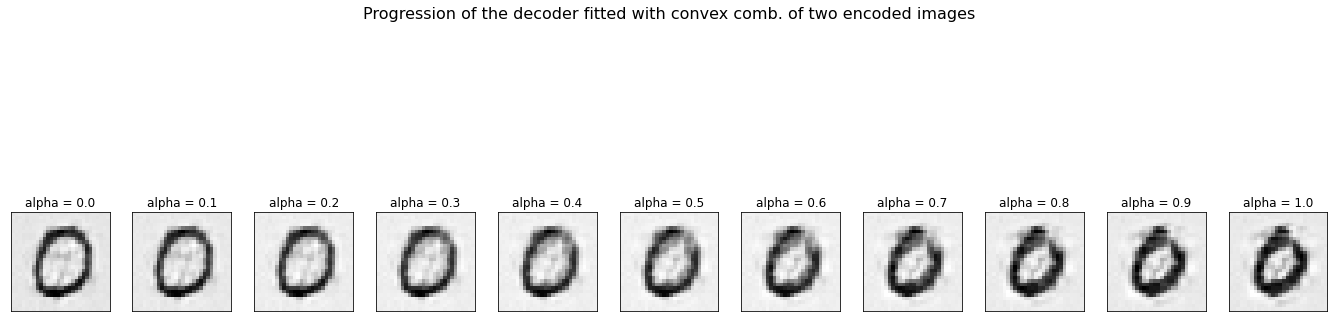

In [298]:
latent_space_interpolation(model, z1, z2)

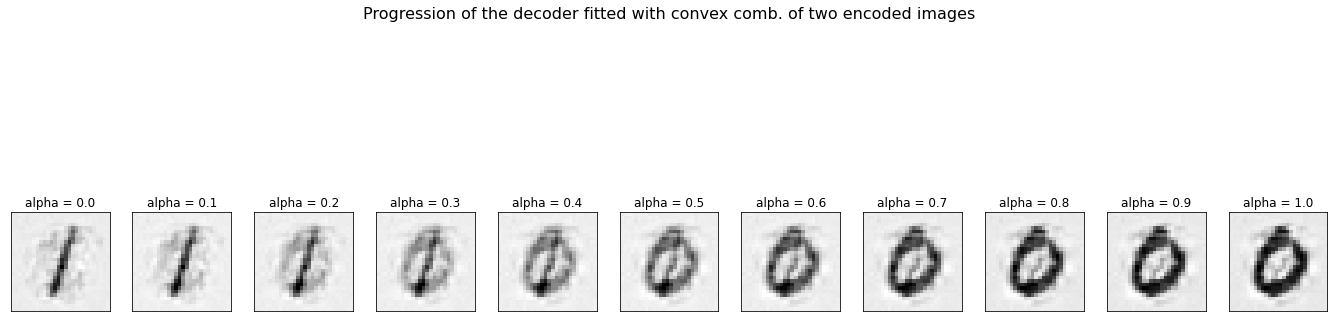

In [299]:
latent_space_interpolation(model, z1, z3)

## Iterative Gradient Ascent

In [328]:
def iterative_gradient_ascent(model):
  with torch.no_grad():
    rand_img = torch.rand(784)

    gradient_ascent_images = [rand_img.clone()]

    for i in range(24):
      recon = model(rand_img)
      delta_p = recon - rand_img
      rand_img += delta_p
      gradient_ascent_images.append(rand_img.clone())

    show_table_images(gradient_ascent_images, "First 25 iterations of gradient ascent", 5)

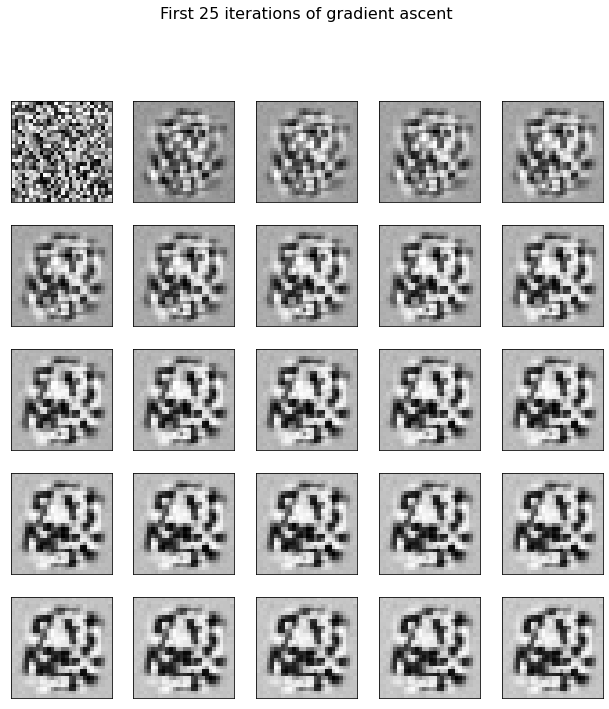

In [329]:
iterative_gradient_ascent(model)

## Iterative Gradient Ascent for a single class learned autoencoder

In [324]:
model_single = AE(input_shape=784, hidden_dimension=128).to(device)

In [325]:
_ = denoising_autoencoder_training(20, 128, X_train[y_train==4], model_single, 1e-3, X_test = X_test[y_test==4])

epoch : 1/20, train loss = 0.068335, test loss = 0.068645
epoch : 2/20, train loss = 0.055182, test loss = 0.055209
epoch : 3/20, train loss = 0.044842, test loss = 0.044719
epoch : 4/20, train loss = 0.036466, test loss = 0.036322
epoch : 5/20, train loss = 0.030565, test loss = 0.030390
epoch : 6/20, train loss = 0.025607, test loss = 0.025396
epoch : 7/20, train loss = 0.021981, test loss = 0.021735
epoch : 8/20, train loss = 0.019852, test loss = 0.019598
epoch : 9/20, train loss = 0.017591, test loss = 0.017329
epoch : 10/20, train loss = 0.016294, test loss = 0.016050
epoch : 11/20, train loss = 0.014969, test loss = 0.014735
epoch : 12/20, train loss = 0.014224, test loss = 0.014002
epoch : 13/20, train loss = 0.013548, test loss = 0.013343
epoch : 14/20, train loss = 0.012774, test loss = 0.012577
epoch : 15/20, train loss = 0.012136, test loss = 0.011948
epoch : 16/20, train loss = 0.011674, test loss = 0.011489
epoch : 17/20, train loss = 0.011224, test loss = 0.011054
epoch 

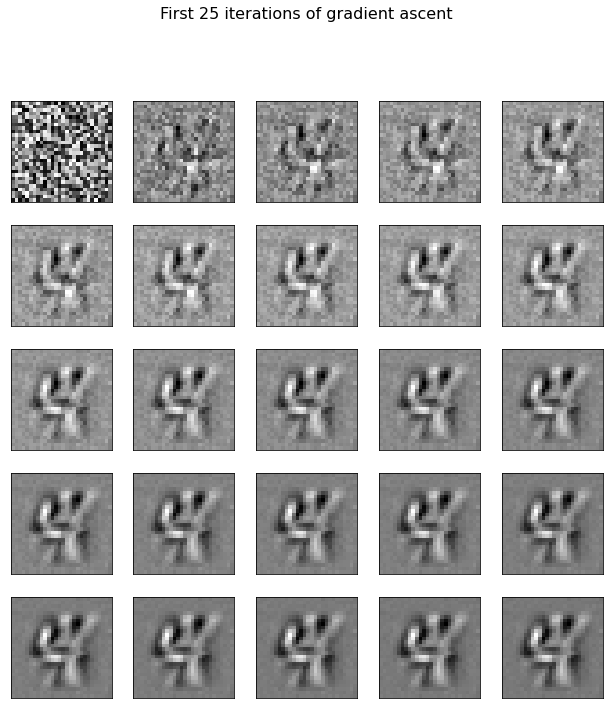

In [330]:
iterative_gradient_ascent(model_single)